Проведите небольшое исследование алгоритма градиентного спуска. Оцените влияние значений скорости обучения `(alpha)` и количества итераций на ошибку алгоритма. Как связаны эти два гиперпараметра между собой? Подберите скорость обучения и количество итераций до совпадения ответов алгоритма с результатами МНК. Как можно ускорить процесс вычисления весов?

Слишком большое значение alpha может привести к тому, что алгоритм не сойдется и будет осциллировать вокруг минимума. Слишком маленькое значение alpha может привести к тому, что алгоритм будет двигаться слишком медленно и потребуется больше итераций для достижения минимума.

Количество итераций также влияет на производительность алгоритма. Слишком маленькое количество итераций может привести к тому, что алгоритм не сойдется до минимума, а слишком большое количество итераций может привести к переобучению модели.

Чтобы ускорить процесс вычисления весов, можно использовать методы оптимизации, которые используют более эффективные алгоритмы для нахождения минимума функции потерь, например, метод оптимизации на основе стохастического градиентного спуска.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as SklLinearRegression
%matplotlib inline


In [2]:
X_train = np.array([1, 1, 2, 1, 3, 0, 5, 10, 1, 2])  # стаж репетитора
y_train = np.array([45, 55, 50, 59, 65, 35, 75, 80, 50, 60])  # средний балл ЕГЭ (целевая переменная)

# выведем табличку с данными
data_train = pd.DataFrame({'X': X_train, 'Y': y_train})
X = data_train.drop('Y', axis=1)
Y = data_train['Y']

### Решение с помощью линейной алгебры

In [3]:
model_skl = SklLinearRegression()
model_skl.fit(X, Y)

print(model_skl.coef_)
print(model_skl.intercept_)

[3.91071429]
47.232142857142854


### Решение с помощью градиентного спуска

In [4]:
class MyLinearRegression:
    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 fit_intercept: bool = True, copy: bool = True):
        self.weight = None
        self.fit_intercept = fit_intercept
        self.samples = samples.copy() if copy else samples
        self.samples = np.hstack((self.samples, np.ones((self.samples.shape[0], 1))))
        self.targets = targets

    def fit(self):
        self.weight = np.linalg.inv(
            self.samples.T @ self.samples) @ self.samples.T @ self.targets
        return self

    def predict(self):
        return self.samples @ self.weight

    def get_weights(self):
        return self.weight


class MyGradientLinearRegression(MyLinearRegression):
    def __init__(self,
                 iters: int = 1000000,
                 alpha: float = 1e-3,
                 diff_mse: float = 1e-6,
                 print_cost: bool = False, **kwargs):
        super().__init__(**kwargs)
        self.iters = iters
        self.alpha = alpha
        self.diff_mse = diff_mse
        self.weight = np.ones(self.samples.shape[1])
        self.print_cost = print_cost
        self.loss_dict = {}

    def mean_squared_error(self):
        loss = self.samples @ self.weight - self.targets.values
        return np.mean(np.square(loss))

    def iteration(self):
        self.weight -= self.alpha * self._calc_gradient()

    def fit(self):
        previous_cost = self.mean_squared_error()
        self.iteration()
        current_cost = self.mean_squared_error()

        self.loss_dict[0] = previous_cost
        self.loss_dict[1] = current_cost

        count = 1
        for _ in range(self.iters):
            current_cost = self.mean_squared_error()
            if previous_cost and abs(previous_cost - current_cost) <= self.diff_mse:
                break

            previous_cost = current_cost

            self.iteration()
            current_cost = self.mean_squared_error()
            self.loss_dict[count + 1] = current_cost

            if count % 100 == 0 and self.print_cost == True:
                print(f"Cost at iteration {count} is {current_cost}")

            count += 1

        print(f'Model alpha: {self.alpha}, diff_mse: {self.diff_mse}, iterations: {count} ...')

    def _calc_gradient(self):
        pred = self.samples @ self.weight - self.targets.values
        return 2 * pred @ self.samples / self.samples.shape[0]


In [24]:
def plot_learning_curves(samples=X, targets=Y, learning_rates=None, diff_mse_values=None):
    if diff_mse_values is None:
        diff_mse_values = [1e-2, 1e-3, 1e-4, 1e-6]
    if learning_rates is None:
        learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]

    fig = plt.figure()
    fig.set_size_inches(13, 10)
    
    for item, diff_mse in enumerate(diff_mse_values):
        ax = fig.add_subplot(2, 2, item + 1)
        mse_values = []
        
        for lr in learning_rates:
            model = MyGradientLinearRegression(samples=samples, targets=targets, alpha=lr, diff_mse=diff_mse)
            model.fit()
            learning_path = model.loss_dict
            
            plt.plot(learning_path.keys(), learning_path.values())
            plt.title(f'diff_mse = {diff_mse}')
            plt.ylim(0, 1200)
            plt.xlim(0, 1200)
            
            mse_values.append(str(round(list(learning_path.values())[-1], ndigits=4)))
        
        plt.ylabel('Среднеквадратическая ошибка')
        plt.xlabel('Номер итерации')
        plt.legend([f'Скорость обучения равна {learning_rates[i]} с MSE = {mse_values[i]}' for i in range(len(learning_rates))])
        # plt.legend([f'Learning rate equals to {rates[i]} with Q = {Q_values[i]}' for i in range(len(rates))])
    
    fig.tight_layout()
    plt.show()

In [5]:
model_lr = MyLinearRegression(samples=X, targets=Y)
model_lr.fit()
print(f'Вес и bias: {model_lr.get_weights()}')

Вес и bias: [ 3.91071429 47.23214286]


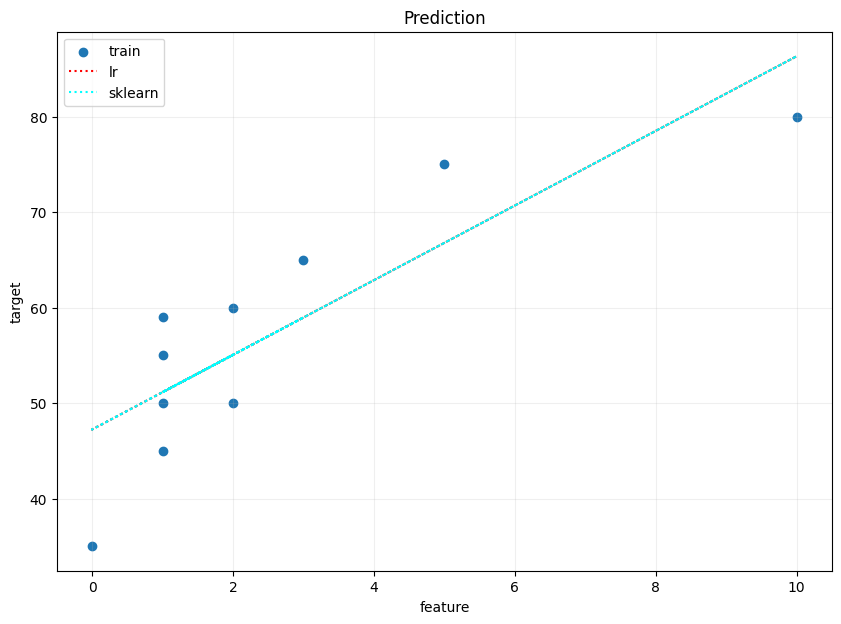

In [6]:
plt.figure(figsize=(10, 7))

plt.scatter(X, Y, label='train')
plt.plot(X, model_lr.predict(), label='lr', c='r', linestyle=':')
plt.plot(X, model_skl.predict(X), label='sklearn', c='cyan', linestyle=':')

plt.title("Prediction")
plt.ylabel('target')
plt.xlabel('feature')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [7]:
model_glr = MyGradientLinearRegression(
    samples=X, targets=Y, alpha=1e-2, diff_mse=1e-6, print_cost=True)
model_glr.fit()
print(f'Вес и bias: {model_glr.get_weights()}')

Cost at iteration 100 is 173.03354817322213
Cost at iteration 200 is 61.6506144779989
Cost at iteration 300 is 47.88014078346632
Cost at iteration 400 is 46.1776721962168
Cost at iteration 500 is 45.96719292332711
Cost at iteration 600 is 45.941170989854754
Cost at iteration 700 is 45.93795385112017
Cost at iteration 800 is 45.93755611043545
Model alpha: 0.01, diff_mse: 1e-06, iterations: 810 ...
Вес и bias: [ 3.9124314  47.22284397]


### Зависимость влияния скорости обучения `(alpha)` и количества итераций на ошибку алгоритма

Model alpha: 0.01, diff_mse: 0.01, iterations: 369 ...
Model alpha: 0.001, diff_mse: 0.01, iterations: 2590 ...
Model alpha: 0.0001, diff_mse: 0.01, iterations: 14827 ...
Model alpha: 0.01, diff_mse: 0.001, iterations: 479 ...
Model alpha: 0.001, diff_mse: 0.001, iterations: 3696 ...
Model alpha: 0.0001, diff_mse: 0.001, iterations: 25899 ...
Model alpha: 0.01, diff_mse: 1e-06, iterations: 810 ...
Model alpha: 0.001, diff_mse: 1e-06, iterations: 7016 ...
Model alpha: 0.0001, diff_mse: 1e-06, iterations: 59115 ...


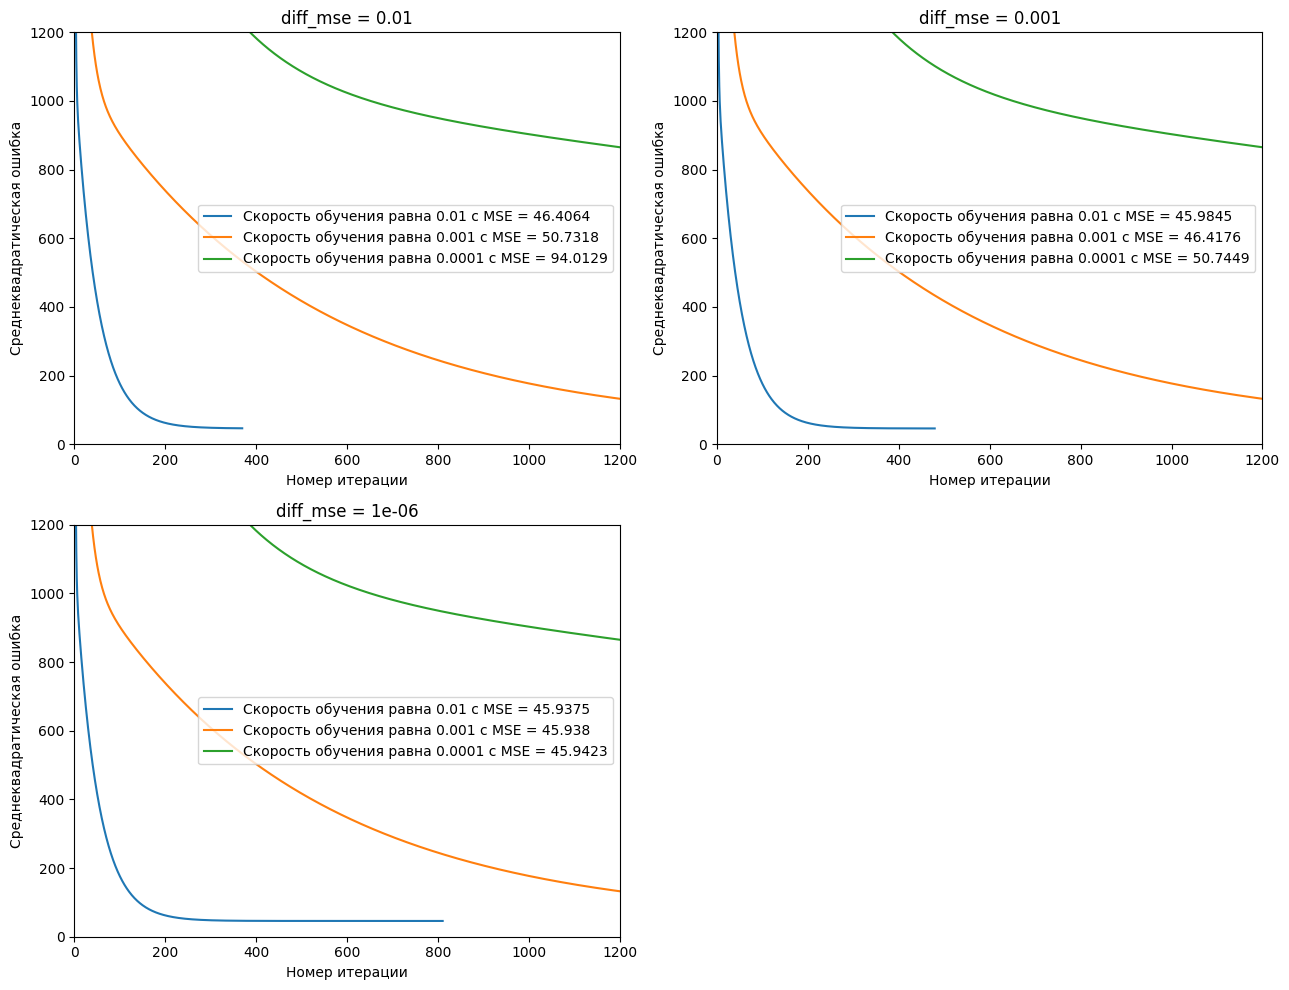

In [31]:
mse_values = [1e-2, 1e-3, 1e-6]
alpha = [1e-2, 1e-3, 1e-4]
plot_learning_curves(learning_rates=alpha, diff_mse_values=mse_values)

*2. В этом коде мы избавляемся от итераций по весам, но тут есть ошибка, исправьте ее:

In [8]:
X_arr = X.to_numpy()
y_arr = Y.to_numpy()
n = X.shape[0]
w = np.array([1, 0.5])
alpha = 1e-2

In [9]:
X_arr = np.hstack((X_arr, np.ones((n, 1))))

In [10]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [11]:

for i in range(1001):
    y_pred = np.dot(w, X_arr.T)
    err = calc_mse(y_arr, y_pred)
    # w -= (alpha * (1/n * 2 * np.sum(X.T * (y_pred - y)))) # ошибка!
    w -= (alpha * (1/n * 2 * np.dot(X_arr.T, (y_pred - y_arr))))
    # w -= 2 * alpha * X.T @ (y_pred - y) / n
    if i % 100 == 0:
        print(i, w, err) # [47.23214286  3.91071429] 45.937499999999986

0 [4.28  1.586] 3060.85
100 [ 6.78098547 31.68839913] 178.57410436712183
200 [ 4.91993939 41.7667581 ] 62.33560346859194
300 [ 4.26557111 45.31044169] 47.96482721219526
400 [ 4.03548661 46.55644745] 46.18814213268195
500 [ 3.95458588 46.99455946] 45.96848734052277
600 [ 3.92614011 47.14860541] 45.94133102099555
700 [ 3.91613821 47.20276999] 45.937973636059795
800 [ 3.91262141 47.22181497] 45.93755855648333
900 [ 3.91138486 47.22851144] 45.93750723944403
1000 [ 3.91095007 47.230866  ] 45.93750089502558


3(*). Вместо того, чтобы задавать количество итераций, задайте условие остановки алгоритма - когда ошибка за итерацию начинает изменяться ниже определенного порога. Сколько нужно сделать итераций, если установить допустимое отклонение mse в размере diff=1e-6, а значение alpha=1e-2?

In [32]:
mse_values = [1e-6]
alpha = [1e-2]

Model alpha: 0.01, diff_mse: 1e-06, iterations: 810 ...


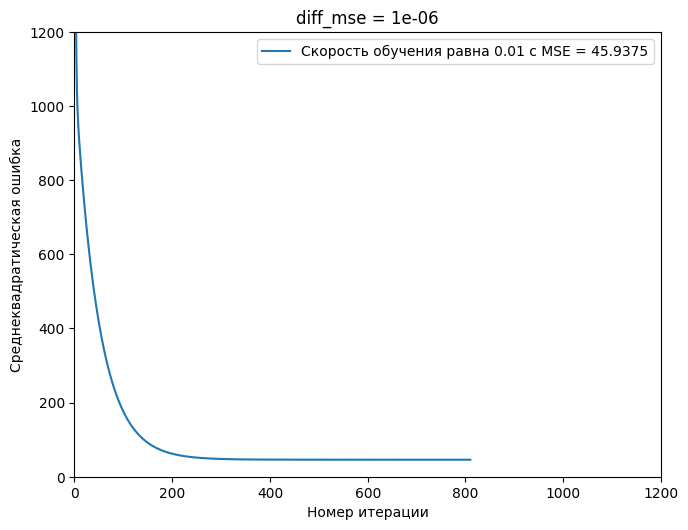

In [33]:
plot_learning_curves(learning_rates=alpha, diff_mse_values=mse_values)